GPU CONFIG

In [1]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#     raise SystemError('GPU device not found')

In [2]:
import pandas as pd
import numpy as np
import tensorflow
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow_addons as tfa
import keras
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,Activation
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization
import IPython.core.display         
# setup output image format (Chrome works best)
#IPython.core.display.set_matplotlib_formats("svg")
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder
from tensorflow.keras.optimizers import Adam
%matplotlib inline


# Train Dataset Paths 

In [3]:
#Train
train_image_path = '../input/resized-plant2021/img_sz_512'
train_df_path = '../input/plant-pathology-2021-fgvc8/train.csv'

#Test
# test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
# test_df_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'


In [4]:
df_train_org = pd.read_csv(train_df_path)

In [5]:
df_train = df_train_org.copy()
print(f'Train Set Shape {df_train.shape}')

print(f"\nTrain  set \n {df_train.head()}")

Train Set Shape (18632, 2)

Train  set 
                   image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex


# Label Count

In [6]:
source = df_train['labels'].value_counts()
source

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

# Plotting Bar Chart

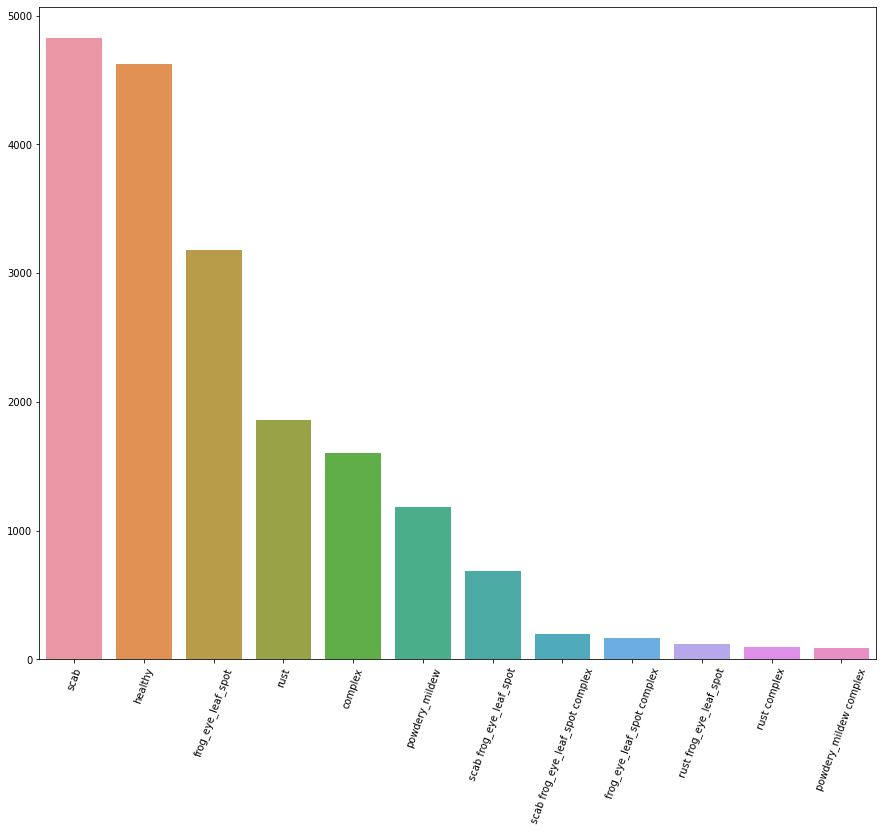

In [7]:
plt.figure(figsize=(15,12))
labels = sns.barplot(x= source.index,y = source.values)
for item in labels.get_xticklabels():
    item.set_rotation(70)

# Pie chart 

In [8]:
import plotly.graph_objects as grp_obj
pie_chart = grp_obj.Figure(data=[grp_obj.Pie(labels=source.index,values=source.values)])
pie_chart.update_layout(title='Label distribution and percentage')
pie_chart.show()

# Visualization of Images 

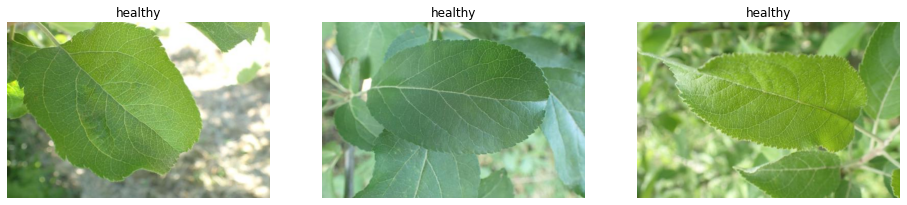

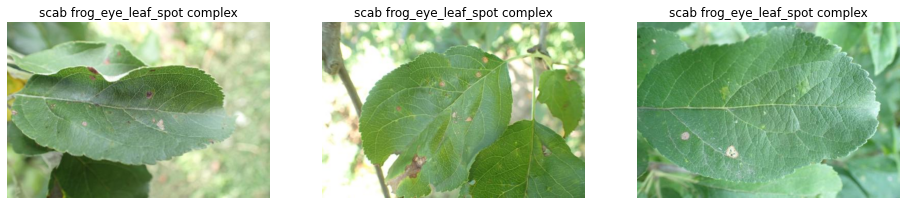

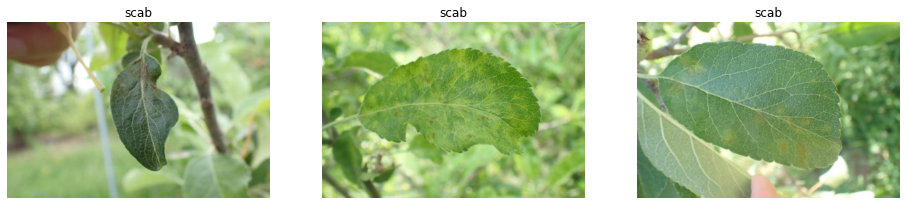

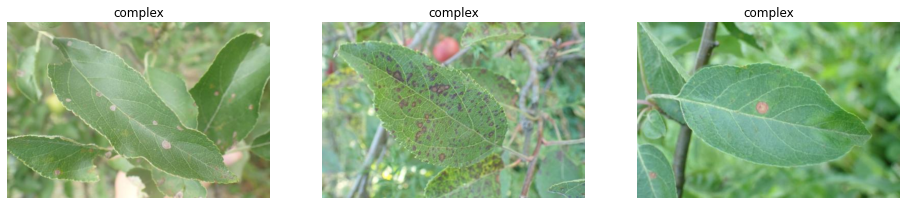

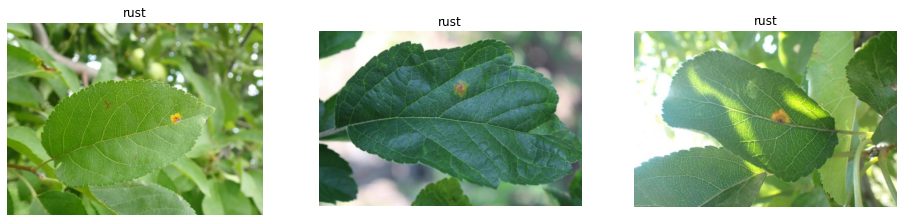

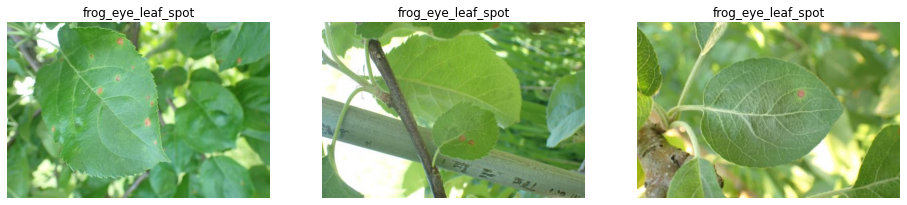

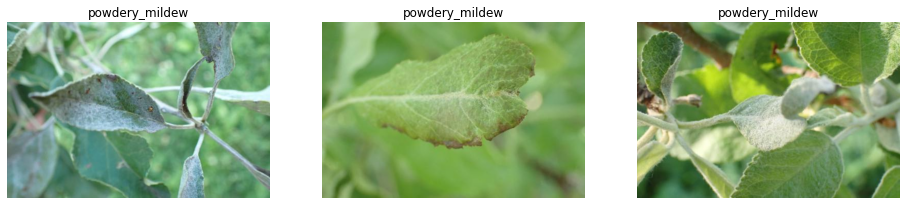

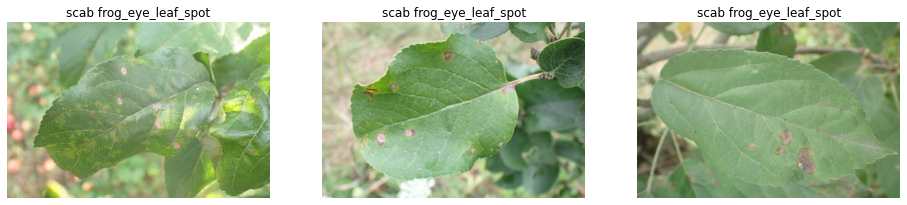

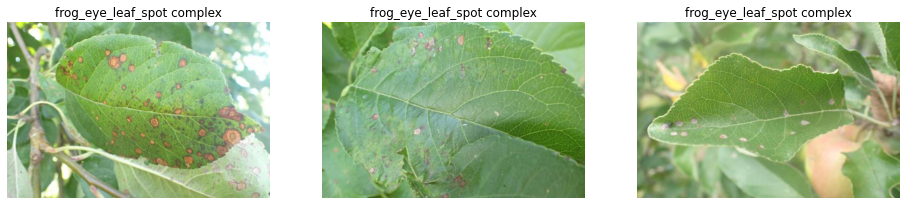

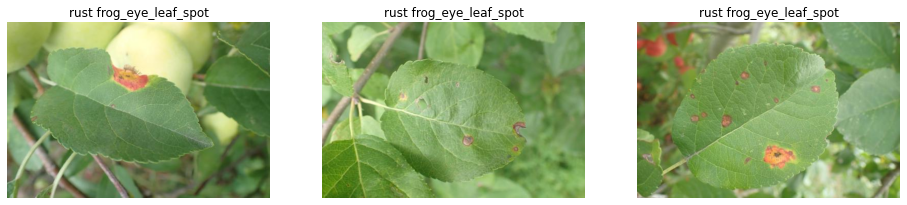

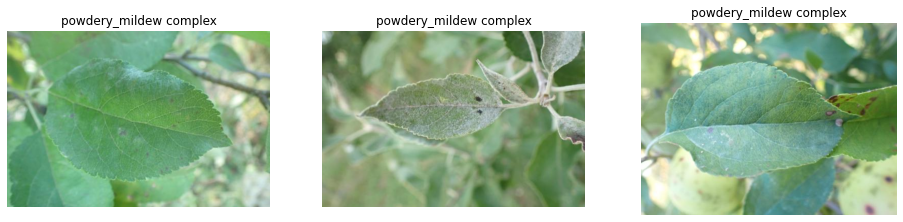

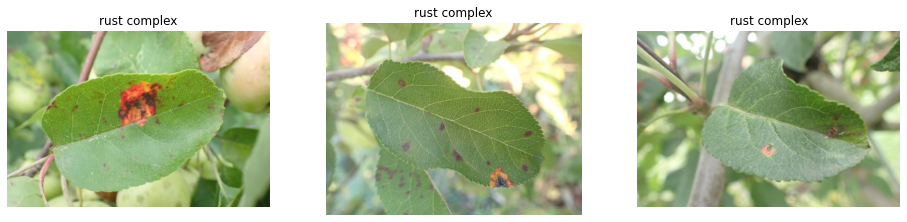

In [9]:
def batch_visualize(df_train,path,label):
    sample_df   = df_train[df_train['labels']==label].sample(3)
    image_names = sample_df['image'].values
    #print(image_names)
    labels = sample_df['labels'].values
    plt.figure(figsize=(16,12))
    
    for image_index, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(3, 3, image_index+1 )
        #print('______',image_index+1,image_index)
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f'{label}',fontsize=12)
        plt.axis("off")    
    plt.show()
        

#loopoing on label values
lab_l = df_train['labels'].unique().tolist()
for i in lab_l:
    batch_visualize(df_train,train_image_path,i)        
        

# This is clearly  a multilabel classifaction problem
**Handling Multilabels**

In [10]:
df_train['labels'] = df_train['labels'].apply(lambda string : string.split(' '))
df_train

image                               labels
0      800113bb65efe69e.jpg                            [healthy]
1      8002cb321f8bfcdf.jpg  [scab, frog_eye_leaf_spot, complex]
2      80070f7fb5e2ccaa.jpg                               [scab]
3      80077517781fb94f.jpg                               [scab]
4      800cbf0ff87721f8.jpg                            [complex]
...                     ...                                  ...
18627  fffb900a92289a33.jpg                            [healthy]
18628  fffc488fa4c0e80c.jpg                               [scab]
18629  fffc94e092a59086.jpg                               [rust]
18630  fffe105cf6808292.jpg           [scab, frog_eye_leaf_spot]
18631  fffe472a0001bd25.jpg                            [healthy]

[18632 rows x 2 columns]

**Global Paramaters**

In [11]:
#labels_actual = df_train['labels'].unique().tolist()
df_train.shape


(18632, 2)

In [12]:
HEIGHT = 256 #
WIDTH  = 256
BATCH_SIZE = 128
SEED = 40

# Data Generation - Augmentation

In [13]:
train_data_gen = ImageDataGenerator(rescale = 1/255.,
                       rotation_range=20,
                       width_shift_range=0.2,
                       height_shift_range=0.2,
                       horizontal_flip=True,
                       validation_split=0.2,
                       zoom_range= 0.2,
                       shear_range= 0.2,
                       vertical_flip=True,
                       )

train_dataset = train_data_gen.flow_from_dataframe(df_train,
                      directory = train_image_path,
                      x_col = 'image',
                      y_col = 'labels',
                      target_size= (HEIGHT,WIDTH),
                      class_mode='categorical',#supports multilabel
                      batch_size=BATCH_SIZE,
                      subset='training',
                      shuffle= True,
                      seed = SEED,
                      color_mode = 'rgb',
                      validate_filenames = False
                      )

validation_dataset = train_data_gen.flow_from_dataframe(df_train,
                    directory = train_image_path,
                    x_col = "image",
                    y_col = "labels",
                    target_size = (HEIGHT,WIDTH),
                    class_mode='categorical',
                    batch_size = BATCH_SIZE,
                    subset = "validation",
                    shuffle = True,
                    seed = SEED,
                    color_mode = 'rgb',
                    validate_filenames = False
                 )
    

Found 14906 non-validated image filenames belonging to 6 classes.
Found 3726 non-validated image filenames belonging to 6 classes.


# Transfer learning 
# Creating Model with ResNet50v2 

In [14]:
import tensorflow as tf
def create_model():
    base_model = ResNet50V2(weights='imagenet',include_top=False,input_shape=[HEIGHT,WIDTH,3])
    # freezing the layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64,activation = 'relu')(x)
    x = Dense(16,activation = 'relu')(x)
    output = Dense(6,activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs=base_model.input ,outputs = output)
    return model

# Model Summary

In [15]:
model = create_model()
model.summary()

2021-12-21 15:05:04.817585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:05:04.918121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:05:04.918838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 15:05:04.919942: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_____________________________

# Model Complileing

In [16]:
def complile_model(model,lr = 0.0001):
    optimizer = Adam(learning_rate=lr)
    
    metrics = [tfa.metrics.F1Score(num_classes=6,average='macro',name='f1_score')]
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy' , metrics = metrics)
    
    return model

# Callbacks

In [17]:
from keras.callbacks import EarlyStopping

METRIC = "val_f1_score"
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
def create_callbacks(metric = METRIC):
 
    
    reducelr = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.2,
        patience=3,
        verbose=1)
    
    
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
     
    
    
    callbacks = [reducelr,early_stopping]         
    
    return callbacks

    
    

# Training model on GPU

In [18]:
with tf.device('/device:GPU:0'):
    model = create_model()
    model = complile_model(model,lr=0.0001)
    callbacks = create_callbacks()

    historical = model.fit(train_dataset, 
      #steps_per_epoch=STEPS_PER_EPOCH, 
      epochs=20,
      callbacks=callbacks,             
      validation_data=validation_dataset,
      verbose = 1)


2021-12-21 15:05:13.952353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-21 15:05:22.768459: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 508s 4s/step - loss: 0.2734 - f1_score: 0.6255 - val_loss: 0.4956 - val_f1_score: 0.6526
Epoch 2/20
117/117 [==============================] - 339s 3s/step - loss: 0.1325 - f1_score: 0.8308 - val_loss: 0.2304 - val_f1_score: 0.7660
Epoch 3/20
117/117 [==============================] - 337s 3s/step - loss: 0.1134 - f1_score: 0.8535 - val_loss: 0.1312 - val_f1_score: 0.8073
Epoch 4/20
117/117 [==============================] - 346s 3s/step - loss: 0.1029 - f1_score: 0.8653 - val_loss: 0.1192 - val_f1_score: 0.8383
Epoch 5/20
117/117 [==============================] - 336s 3s/step - loss: 0.0949 - f1_score: 0.8745 - val_loss: 0.1300 - val_f1_score: 0.8437
Epoch 6/20
117/117 [==============================] - 336s 3s/step - loss: 0.0895 - f1_score: 0.8811 - val_loss: 0.1322 - val_f1_score: 0.8229
Epoch 7/20
117/117 [==============================] - 347s 3s/step - loss: 0.0850 - f1_score: 0.8848 - val_loss: 0.1027 - val_f1_score: 0.8652
Epoch 8/20

# Plotting Training and validation F1 scores

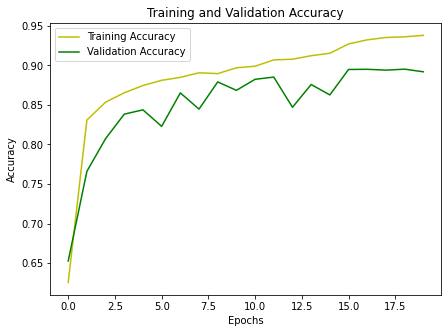

In [25]:
acc_train=historical.history['f1_score']
acc_val=historical.history['val_f1_score']
epochs=range(0,20)
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)
plt.plot(epochs,acc_train,'y',label='Training Accuracy')
plt.plot(epochs,acc_val,'g',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plotting Training and validation loss

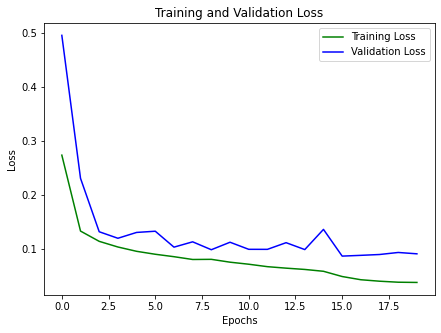

In [27]:
loss_train= historical.history['loss']
loss_val  = historical.history['val_loss']
epochs=range(0,20)
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
model.save("Final_apple_leaf_desease_detector_ResNet50_V2.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



# Loading the Model

In [30]:
from keras.models import load_model
model = load_model("Final_apple_leaf_desease_detector_ResNet50_V2.h5")

In [33]:
 loss,F1 = model.evaluate_generator(validation_dataset,verbose =1 )

30/30 [==============================] - 63s 2s/step - loss: 0.0910 - f1_score: 0.8901


# Loading Test set

In [35]:
df_test = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
test_img_path = '../input/plant-pathology-2021-fgvc8/test_images'
df_test.head()

image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy

In [41]:
for img_name in tqdm(df_test['image']):
    path = test_img_path+ '/' +str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./{img_name}')

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


In [42]:
test_data = train_data_gen.flow_from_dataframe(
    df_test,
    directory = '../input/plant-pathology-2021-fgvc8/test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    shuffle=False,
    seed=40,
)

Found 3 validated image filenames.


In [43]:
prediction = model.predict(test_data)
print(prediction)

[[2.8728710e-03 4.0848623e-04 7.2517426e-04 2.1996409e-05 9.4648181e-05
  9.9614054e-01]
 [9.1464710e-01 1.8091217e-01 3.7105917e-04 7.6880160e-04 2.4364069e-03
  1.6330464e-01]
 [3.5074044e-02 9.9454862e-01 1.0682143e-04 2.0497837e-04 1.0828928e-03
  2.5328594e-01]]


In [64]:
preds = prediction.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.23:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

[[5], [0], [1, 5]]


In [68]:
labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['scab', 'complex', 'frog_eye_leaf_spot scab']


In [69]:
import os
delfiles = tf.io.gfile.glob('./*.jpg')

for file in delfiles:
    os.remove(file)


In [70]:
sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
sub['labels'] = testlabels
sub.to_csv('submission.csv', index=False)
sub

image                   labels
0  85f8cb619c66b863.jpg                     scab
1  ad8770db05586b59.jpg                  complex
2  c7b03e718489f3ca.jpg  frog_eye_leaf_spot scab